# **Data 88 Project by Jacob Luo and Ivan A. Kristanto**

# Setup

## Introduction

**Paper:** Acquired Nisin Resistance in Staphylococcus aureus Involves Constitutive Activation of an Intrinsic Peptide Antibiotic Detoxification Module ([paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6291627), [data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114706)).

The goal of this project is to analyse RNASeq data in order to identify differentially expressed genes between wild type and Nisin-resistant strains of *Staphylococcus aureus*.

## Background

Nisin is a broad-spectrum antibiotic effective against many Gram Positive bacteria. It kills susceptible microbes by creating pores on bacterial membranes and preventing cell wall synthesis. 

In this study, Nisin resistance in *S. aureus* was triggered by mutating the *nsaS* gene, which codes for a set of proteins called NsaRS. NsaRS is a two-component regulatory system that detects the presence of nisin and subsequently triggers changes in transcription that will be reflected by our analyses of the transcriptome.

In [0]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('fivethirtyeight')
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import random
import scipy.stats as stats
import statsmodels.api as sm

## Data Cleanup
There are five samples in total, with two (samples 1 and 2) being wild-type strains and three (samples 3, 4, and 5). Each sample has 4 columns: features, expression value, unique reads, and total reads. For our analyses, we will only use the last column.

In [0]:
raw1 = pd.read_csv("https://raw.githubusercontent.com/ivalexander13/mrsa-nisin-resistance/master/samples_raw/GSM3147945_WT1_S7.txt", delimiter = "\t")
raw2 = pd.read_csv("https://raw.githubusercontent.com/ivalexander13/mrsa-nisin-resistance/master/samples_raw/GSM3147946_WT3_S9.txt", delimiter = "\t")
raw3 = pd.read_csv("https://raw.githubusercontent.com/ivalexander13/mrsa-nisin-resistance/master/samples_raw/GSM3147947_SM1_S4.txt", delimiter = "\t")
raw4 = pd.read_csv("https://raw.githubusercontent.com/ivalexander13/mrsa-nisin-resistance/master/samples_raw/GSM3147948_SM2_S5.txt", delimiter = "\t")
raw5 = pd.read_csv("https://raw.githubusercontent.com/ivalexander13/mrsa-nisin-resistance/master/samples_raw/GSM3147949_SM3_S6.txt", delimiter = "\t")


# function for data preprocessing 

def preproc(*dfs):
  list_df = []
  for df in dfs:
    df.drop(df.columns[[1, 2]], axis=1, inplace=True)
    df = df.rename({df.columns[0]: "feature", df.columns[1]: "reads_" + str(len(list_df) + 1)}, axis='columns')
    list_df.append(df)
  return list_df

raw1, raw2, raw3, raw4, raw5 = preproc(raw1, raw2, raw3, raw4, raw5)


# combine the five samples into one dataframe

raws = pd.merge(raw1, raw2, on='feature')
raws = pd.merge(raws, raw3, on='feature')
raws = pd.merge(raws, raw4, on='feature')
raws = pd.merge(raws, raw5, on='feature')


In [6]:
raws

,feature,reads_1,reads_2,reads_3,reads_4,reads_5
0,SAOUHSC_01037,10,180,6,10,4
1,SAOUHSC_00303,4,3,1,1,0
2,SAOUHSC_00978,94,257,24,62,23
3,SAOUHSC_02313,3,6,1,1,1
4,SAOUHSC_02518,6,9,0,4,1
...,...,...,...,...,...,...
2867,SAOUHSC_02939,0,0,1,1,0
2868,SAOUHSC_02948,0,5,0,0,0
2869,SAOUHSC_02950,1,1,0,0,0
2870,SAOUHSC_A01436,0,0,0,1,0


# Exploratory Data Analysis

A histogram of the raw values show a significant majority of features not being expressed. A histogram of the log of the raw values tell a different story.

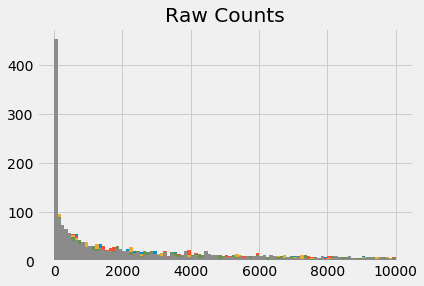

In [9]:
histrange = [0, 10000]
raws.iloc[:, 1].hist(bins=100, range=histrange)
raws.iloc[:, 2].hist(bins=100, range=histrange)
raws.iloc[:, 3].hist(bins=100, range=histrange)
raws.iloc[:, 4].hist(bins=100, range=histrange)
raws.iloc[:, 5].hist(bins=100, range=histrange)
plt.title('Raw Counts')
plt.show()

**Filter**: We will use the index of dispersion, mean/variance, of each gene and discard the ones with a low value. The raw counts data will be fitered instead of the log counts data. Our threshold for the cutoff is 1.

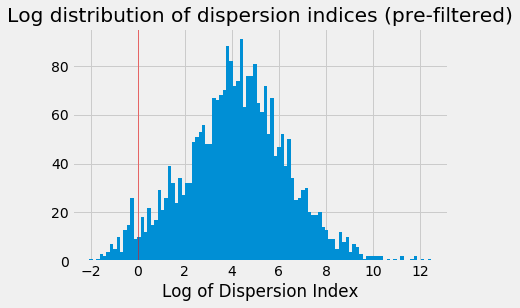

In [11]:
index_dispersion_per_gene = np.var(raws, axis=1) / np.mean(raws, axis=1)

histrange = [0, 10000]
np.log(index_dispersion_per_gene).hist(bins=100, range=None)
plt.axvline(x=0, color='red', linewidth=0.5)
plt.title('Log distribution of dispersion indices (pre-filtered)')
plt.xlabel('Log of Dispersion Index')
plt.show()

filtered_raw = raws[index_dispersion_per_gene > 1]

**Normalization**: The filtered data is then normalized by median normalization.

In [0]:
design_temp=filtered_raw.iloc[:,1:6]
design_norm=(design_temp/np.median(design_temp,axis=0))*np.median(design_temp)
design_norm_transform=design_norm.apply(lambda x: np.log(x+1), axis=0)
design_norm_centered=design_norm_transform-np.median(design_norm_transform,axis=0)

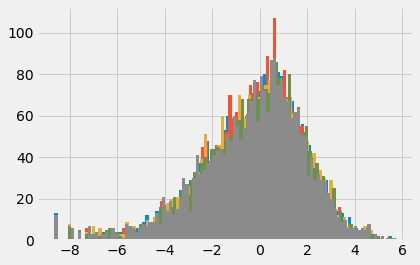

In [13]:
design_norm_centered.iloc[:, 0].hist(bins=100)
design_norm_centered.iloc[:, 1].hist(bins=100)
design_norm_centered.iloc[:, 2].hist(bins=100)
design_norm_centered.iloc[:, 3].hist(bins=100)
design_norm_centered.iloc[:, 4].hist(bins=100)
plt.show()

## **Principal Component Analysis**



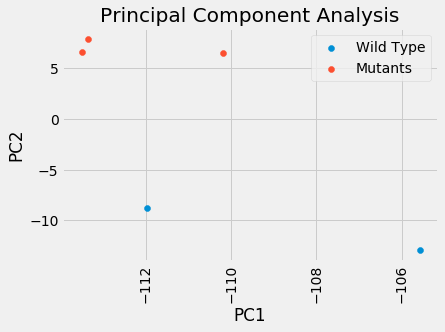

In [17]:
u, s, vt = np.linalg.svd(design_norm_centered.T.iloc[:,:], full_matrices = False) 
PCS=pd.DataFrame(u*s)
plt.scatter(PCS.iloc[0:2,0],PCS.iloc[0:2,1])
plt.scatter(PCS.iloc[2:5,0],PCS.iloc[2:5,1])
plt.xticks(rotation=90)
plt.legend(['Wild Type', 'Mutants'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('Principal Component Analysis')
plt.show();

Top two points are control group, bottom 3 are treatment groups. PC2 is negative for treatment groups, and positive for control groups. Clustering seems to occur only along pc2, meaning that most of the captured variance comes from genes that are differentially expressed without regard to the treatment vs control conditions. 


## **EDA on Mean Gene Expression**

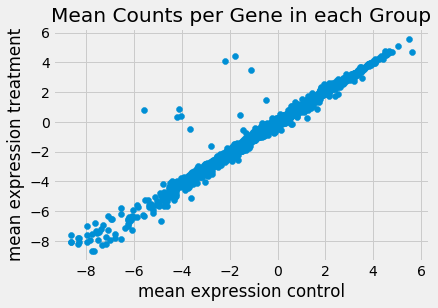

In [23]:
means_control=np.mean(design_norm_centered.iloc[:,:2],axis=1)
means_treatment=np.mean(design_norm_centered.iloc[:,2:5],axis=1)
plt.scatter(means_control,means_treatment)
plt.xlabel("mean expression control")
plt.ylabel("mean expression treatment")
plt.title('Mean Counts per Gene in each Group')
plt.show();

Extract the outliers using mean squared error, with a threshold of 4.

In [24]:
labels=filtered_raw["feature"].to_list()
df_mean_expr=pd.DataFrame({"gene":labels,"control means":means_control,"treatment means":means_treatment})
df_mean_expr["mse"]=(df_mean_expr["treatment means"]-df_mean_expr["control means"])**2
df_diffexpr=df_mean_expr[df_mean_expr["mse"]>4]
df_diffexpr["gene"]

2840     SAOUHSC_02954
2841     SAOUHSC_03041
2842     SAOUHSC_3042a
2843     SAOUHSC_00355
2844     SAOUHSC_03040
2845     SAOUHSC_03042
2846     SAOUHSC_03037
2847     SAOUHSC_03036
2848    SAOUHSC_03037a
Name: gene, dtype: object

Write a function that takes two arrays as input and performs a permutation test for the difference of medians.

In [0]:
def medians_permutation_test(array_1, array_2, num_perm = 1000, test_type = 'two-sided'):
    true_diff = np.median(array_1) - np.median(array_2)
    null_diffs = make_array()
    merged_array = np.append(array_1, array_2)
    for i in np.arange(num_perm):
        shuffled_array = random.sample(list(merged_array), k = len(merged_array))
        group_1 = shuffled_array[:len(array_1)]
        group_2 = shuffled_array[len(array_1):]
        diff_medians = np.median(group_1) - np.median(group_2)
        null_diffs = np.append(null_diffs, diff_medians)
    if test_type == 'two-sided':
            p_val = np.sum(np.abs(null_diffs) >= np.abs(true_diff))/num_perm
    elif test_type == 'greater':
            p_val = np.sum(null_diffs >= true_diff)/num_perm
    elif test_type == 'less':
            p_val = np.sum(null_diffs <= true_diff)/num_perm
    else:
        return "test_type improperly specified; choices are 'two-sided', 'greater', 'less'"
        
    return [p_val, null_diffs, true_diff]

# Permutation Testing


Do a permutation test on the mean counts by shuffling the sample labels.

In [0]:
def means_permutation_test(array_1, array_2, num_perm = 500, test_type = 'two-sided'):
    true_diff = np.mean(array_1) - np.mean(array_2)
    null_diffs = np.array([])
    merged_array = np.append(array_1, array_2)
    for i in np.arange(num_perm):
        shuffled_array = random.sample(list(merged_array), k = len(merged_array))
        group_1 = shuffled_array[:len(array_1)]
        group_2 = shuffled_array[len(array_1):]
        diff_means = np.mean(group_1) - np.mean(group_2)
        null_diffs = np.append(null_diffs, diff_means)
    if test_type == 'two-sided':
            p_val = np.sum(np.abs(null_diffs) >= np.abs(true_diff))/num_perm
    elif test_type == 'greater':
            p_val = np.sum(null_diffs >= true_diff)/num_perm
    elif test_type == 'less':
            p_val = np.sum(null_diffs <= true_diff)/num_perm
    else:
        return "test_type improperly specified; choices are 'two-sided', 'greater', 'less'"
        
    return [p_val, null_diffs, true_diff]

In [0]:
p_vals=[]
for i in range(filtered_raw.shape[0]):
    array_1 = np.array(filtered_raw.iloc[i,1:3])
    array_2 = np.array(filtered_raw.iloc[i,3:6])
    normal_perm = means_permutation_test(array_1, array_2,test_type="two-sided")
    p_vals.append(normal_perm[0])

In [28]:
#genes with p-value of 0 between control/treatment groups
df_gene_pvals=pd.DataFrame({"pvals":p_vals,"gene":filtered_raw["feature"]})
tested_diff_genes=df_gene_pvals[df_gene_pvals["pvals"]==0]["gene"]

tested_diff_genes

0        SAOUHSC_01037
1        SAOUHSC_00303
4        SAOUHSC_02518
5       SAOUHSC_A02577
7        SAOUHSC_02705
             ...      
2798     SAOUHSC_01197
2813     SAOUHSC_00872
2839     SAOUHSC_02953
2843     SAOUHSC_00355
2845     SAOUHSC_03042
Name: gene, Length: 190, dtype: object

We identified 190 genes with a p-value of zero, when running a permutation test on our filtered, raw data with our test statistic as the mean of the two groups (control and treatment). Interestingly, every single p-value exceeded .05 when we ran our permutation on the further log transformed, centered, and scaled data. Furhtermore, increasing the number of permutations increased p-values.

We chose a mean permutation test due to limited numbers of samples, some with high variance. We were afraid that median permutation tests would fail to capture extremeties, which were crucial in determining differential expression. However, now that I think of it, this concern is not too relevant, as we run many permutations. 


# Alternative test: Generate p-vals from MannWhitneyU Test

Conduct the MannWhitneyU Test on log transformed data to improve test performance.

In [0]:
gene_p_vals = []
log_filt_raw=filtered_raw.iloc[:,1:].apply(lambda x: np.log(x+1), axis=0)
for i in np.arange(0, log_filt_raw.shape[0]):        
    array_1 = np.array(log_filt_raw.iloc[i,1:3])
    array_2 = np.array(log_filt_raw.iloc[i,3:6])
    p_val = stats.mannwhitneyu(array_1, array_2)[1]
    gene_p_vals.append(p_val)

In [30]:
df_gene_pvals_mwu=pd.DataFrame({"pvals":gene_p_vals,"gene":filtered_raw["feature"]})
ten_mwu_diffexpr_genes=df_gene_pvals_mwu.sort_values("pvals")["gene"][:200]
df_gene_pvals_mwu.sort_values("pvals")

,pvals,gene
1022,0.110336,SAOUHSC_02002
126,0.110336,SAOUHSC_00915
2808,0.110336,SAOUHSC_02805
722,0.122639,SAOUHSC_02828
2589,0.122639,groES
...,...,...
247,0.500000,SAOUHSC_02800
1282,0.500000,SAOUHSC_00214
924,0.500000,SAOUHSC_01638
1163,0.500000,SAOUHSC_00716


In [31]:
#diff expr genes in both mwu and permutation test of means
len(ten_mwu_diffexpr_genes[ten_mwu_diffexpr_genes.isin(tested_diff_genes)])

30

Given the lower 200 p-valued genes from the MWU test, 30/200 of them appeared among the 190 genes identified in our permutation test.

#**Gene Ontology Attempt and Conclusion**


We first inputted the features into *GeneOntology.org*, but the genes from the MWU test did not yield any statistically significant cellular functions, while the genes from the permutation test did. However, none of the traits from the database were specific, such as "intracellular metabolism" and such. As such, we resorted to looking for individual functions of genes that may be shared across many of our differentially expressed genes. We do recognize that this method is far from perfect, as we have no idea if these gene functions are unique to differentially expressed genes. 

For these reasons, we pulled data from *AureoWiki*, a repository of staph aureus research. We joined our gene "locus tags" with information on gene location and function, which is shown below.

In [0]:
locus_tag_to_pan_id = pd.read_excel('https://github.com/ivalexander13/mrsa-nisin-resistance/blob/master/OrthologueTable.xlsx?raw=true')
gene_info = pd.read_excel('https://github.com/ivalexander13/mrsa-nisin-resistance/blob/master/GeneSpecificInformation_COL.xlsx?raw=true')

complete_gene_info = locus_tag_to_pan_id.merge(gene_info, left_on="pan ID", right_on="pan locus tag").drop(columns=['locus tag', 'new locus tag', 'organism', 'pan ID'])

In [39]:
top_genes_info = pd.DataFrame(tested_diff_genes).merge(complete_gene_info, how='inner', left_on='gene', right_on='NCTC8325')
print('The gene products')
print()
print(top_genes_info['product'].value_counts()[counts_genes>1])
print()
print()
print('The location of action associated with the gene products')
print()
print(top_genes_info['LocateP'].value_counts())

The gene products

hypothetical protein                83
HAD superfamily hydrolase            3
acetyltransferase                    3
lipoprotein                          2
maltose ABC transporter permease     2
MutT/nudix family protein            2
Name: product, dtype: int64


The location of action associated with the gene products

Intracellular                      87
Multi-transmembrane                61
N-terminally anchored (No CS)      11
Lipid anchored                      7
LPxTG Cell-wall anchored            3
Secretory(released) (with CS)       1
C-terminally anchored (with CS)     1
Name: LocateP, dtype: int64


## Conclusion

In conclusion, we determined that 190 genes were notably differentially expressed in *Staph. Aureus*, mutagenized so that a mutant master control gene affected other antibiotic-resistance inducing genes. The function of these genes seem to be poorly researched, many of which coding for "hypothetical proteins" inferred from similar genetic codes in other species. However, we noticed that a few of these proteins were hydrolases of the HAD superfamily, acetyltransferases, maltose ABC transporter permeases, and lipoproteins. Most of these proteins were intracellular, a few were transmembrane, and 3 were notably cell-wall anchored, indicating that antibiotic resistance is conferred by a combination of many biological factors. 



During our testing, we noticed that when running statistical tests on log transformed data, we found much higher p-values, which is actually a good thing in our case because we got too many p-values of zero. For this reason, we went back and ran the MWU test on the log-transformed, filtered dataset. Our data was still inconclusive, but at the very least we obtained nonzero p-values.